# New CMD selection

Any star will have an expected position in the CMD given its bp_rp color and the absolute magnitude computed from the implied distance. This means that the position in the CMD will be physical only for stars that have specific absolute magnitude for the implied distane and effective temperature. 

The idea of this notebook is to test different classification criteria for these stars. To get an idea of the gaia CMD and were HVS should fall, I will first plot the CMD for stars with low extinction and well characterized parallaxes (stars within 200pc) and overplot HVS simulated using speedystar.

In [81]:
# imports 

import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from astropy.io import fits
from astropy.table import Table, vstack
from astropy import units as u
import astropy.coordinates as coord
from astropy.coordinates import SkyCoord, Galactocentric, ICRS
from astropy.constants import kpc, au
from astropy.coordinates import CartesianRepresentation, CartesianDifferential
from astropy.coordinates.matrix_utilities import rotation_matrix, matrix_product, matrix_transpose
from numba import njit

import random
import healpy as hp

from matplotlib.gridspec import GridSpec
from scipy.optimize import minimize

In [2]:
# set up the plotting
# set font size
plt.rcParams.update({'font.size': 18})
# set the figure size
plt.rcParams.update({'figure.figsize': (10, 7)})
# set the font to latex
plt.rcParams.update({'text.usetex': True})

# set the path to save plots
plots_path = '/Users/mncavieres/Documents/2024-2/HVS/Plots/new_cmd'

In [3]:
# load gaia stars within 200pc. gaia archive is down for maintenance, so I will use sergeys system. 
#data_gaia = pd.read_feather('/Users/mncavieres/Documents/2024-2/HVS/Data/Gaia_tests/200pc/raw_gaia_catalog/3M_sources_goodruwe.feather')
data_gaia = Table.read('/Users/mncavieres/Documents/2024-2/HVS/Data/Gaia_tests/200pc/raw_gaia_catalog/has_rvs_200pc.fits')

In [4]:
# add some useful columns
data_gaia['bp_rp'] = data_gaia['phot_bp_mean_mag'] - data_gaia['phot_rp_mean_mag']
data_gaia['geometric_distance'] = 1000/data_gaia['parallax']
data_gaia['M_g'] = data_gaia['phot_g_mean_mag'] - 5*np.log10(data_gaia['geometric_distance']) + 5


In [5]:
simulated_catalog_f = Table.read('/Users/mncavieres/Documents/2024-2/HVS/Data/speedystar_catalogs/kappa_1.7_4.3_nocuts.fits')
# add some useful columns
simulated_catalog_f['bp_rp'] = simulated_catalog_f['Gaia_BP'] - simulated_catalog_f['Gaia_RP']
simulated_catalog_f['M_g'] = simulated_catalog_f['Gaia_G'] - 5*np.log10(simulated_catalog_f['dist']*1000) + 5

In [6]:
# drop nan values from astropy table
data_gaia = data_gaia.to_pandas().dropna(subset=['bp_rp', 'M_g'])

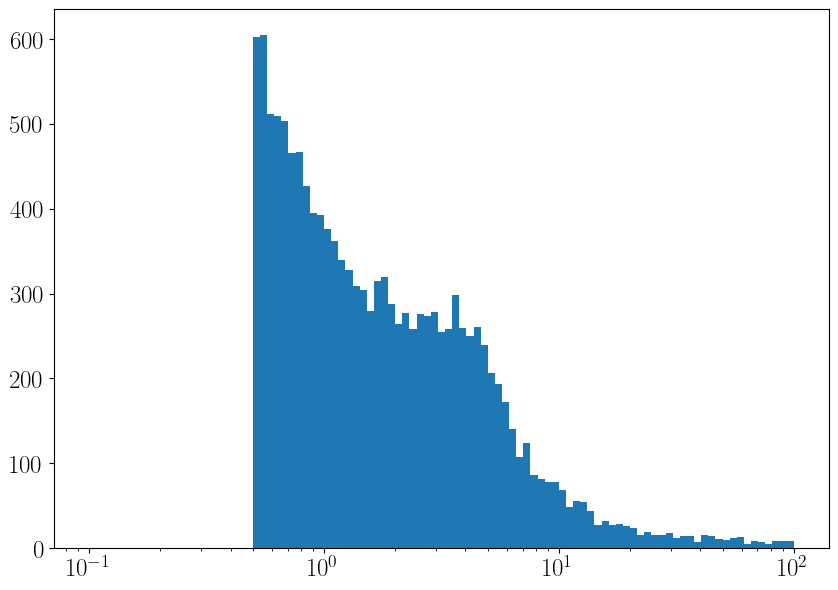

In [7]:
plt.hist(simulated_catalog_f['m'], bins=np.logspace(-1,2,100))
plt.xscale('log')
plt.show()

/var/folders/__/n140hqf972zfmtt1hs5ldglw0000gn/T/ipykernel_46511/2199787104.py:11: UserWarning: Legend does not support handles for QuadMesh instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()
/Users/mncavieres/opt/anaconda3/envs/speedytest2/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


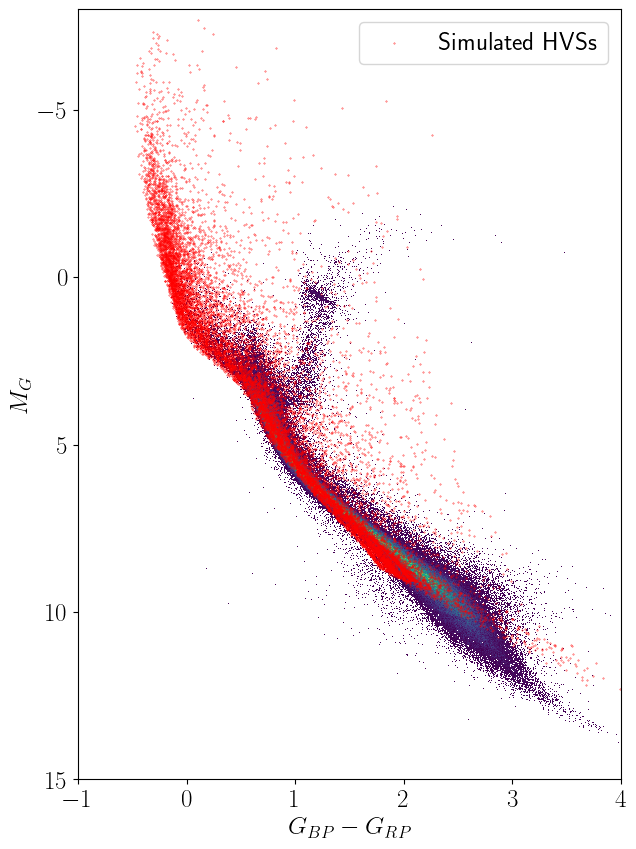

In [8]:

# using hist2d
# plot CMD
plt.figure(figsize=(7, 10))
plt.hist2d(data_gaia['bp_rp'], data_gaia['M_g'], label='Gaia stars', bins= 1000, cmin= 1)
plt.scatter(simulated_catalog_f['bp_rp'], simulated_catalog_f['M_g'], s=0.1, color='red', alpha=0.9, label='Simulated HVSs')
plt.gca().invert_yaxis()
plt.ylim(15, -8)
plt.xlim(-1, 4)
plt.xlabel('$G_{BP} - G_{RP}$')
plt.ylabel('$M_G$')
plt.legend()
plt.show()

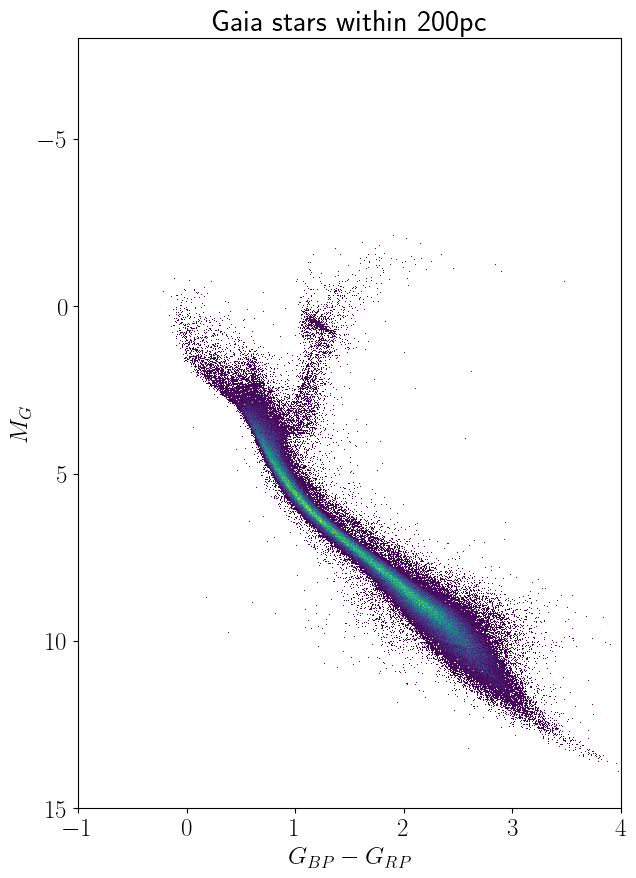

In [9]:

# using hist2d
# plot CMD
plt.figure(figsize=(7, 10))
plt.hist2d(data_gaia['bp_rp'], data_gaia['M_g'], label='Gaia stars', bins= 1000, cmin= 1)
#plt.scatter(simulated_catalog_f['bp_rp'], simulated_catalog_f['M_g'], s=0.1, color='red', alpha=0.9, label='Simulated HVSs')
plt.gca().invert_yaxis()
plt.ylim(15, -8)
plt.xlim(-1, 4)
plt.xlabel('$G_{BP} - G_{RP}$')
plt.ylabel('$M_G$')
plt.title('Gaia stars within 200pc')
plt.show()

# Construct training catalog

In [10]:
simulated_catalog_f = Table.read('/Users/mncavieres/Documents/2024-2/HVS/Data/speedystar_catalogs/kappa_1.7_4.3_nocuts.fits')
# add some useful columns
simulated_catalog_f['bp_rp'] = simulated_catalog_f['Gaia_BP'] - simulated_catalog_f['Gaia_RP']
simulated_catalog_f['M_g'] = simulated_catalog_f['Gaia_G'] - 5*np.log10(simulated_catalog_f['dist']*1000) + 5

In [11]:
# rename the simulated catalog columns to match the gaia catalog
simulated_catalog_gaia = simulated_catalog_f
simulated_catalog_gaia.rename_column('Gaia_G', 'phot_g_mean_mag')
simulated_catalog_gaia.rename_column('Gaia_BP', 'phot_bp_mean_mag')
simulated_catalog_gaia.rename_column('Gaia_RP', 'phot_rp_mean_mag')
simulated_catalog_gaia.rename_column('par', 'parallax')
simulated_catalog_gaia.rename_column('e_par', 'parallax_error')
simulated_catalog_gaia.rename_column('e_pmra', 'pmra_error')
simulated_catalog_gaia.rename_column('e_pmdec', 'pmdec_error')
simulated_catalog_gaia['parallax'] = 1/simulated_catalog_gaia['dist']
simulated_catalog_gaia['is_hvs'] = np.ones(len(simulated_catalog_gaia))


In [12]:
# merge with a large gaia catalog
data_gaia_big = pd.read_feather('/Users/mncavieres/Documents/2024-2/HVS/Data/Gaia_tests/200pc/raw_gaia_catalog/3M_sources_goodruwe.feather')
data_gaia_big['bp_rp'] = data_gaia_big['phot_bp_mean_mag'] - data_gaia_big['phot_rp_mean_mag']

In [13]:
# keep only common columns
simulated_catalog_gaia = simulated_catalog_gaia[['ra', 'dec', 'bp_rp', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag', 'parallax', 'parallax_error', 'pmra', 'pmra_error', 'pmdec', 'pmdec_error', 'is_hvs']]
data_gaia_big = data_gaia_big[['ra', 'dec', 'bp_rp', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag', 'parallax', 'parallax_error', 'pmra', 'pmra_error', 'pmdec', 'pmdec_error']]
data_gaia_big['is_hvs'] = np.zeros(len(data_gaia_big))

# keep only 100000 stars from the big catalog
data_gaia_big = data_gaia_big.sample(n=100000)

# vstack the catalogs
data_gaia_big = data_gaia_big.dropna(subset=['bp_rp', 'phot_g_mean_mag'])
simulated_catalog_gaia = simulated_catalog_gaia.to_pandas().dropna(subset=['bp_rp', 'phot_g_mean_mag'])

# concatenate the catalogs
data_gaia_big = pd.concat([data_gaia_big, simulated_catalog_gaia])

## Compute implied radial velocity and parallax

In [14]:
# Add the path to the 'scripts' folder directly
sys.path.append('/Users/mncavieres/Documents/2024-2/HVS')


In [16]:

# Now you can import from the 'scripts' package
from scripts.implied_d_vr import *  # Or import any other module
from scripts.selections import *


In [17]:
data_gaia_big = implied_calculations(data_gaia_big)

In [18]:
# keep only positive implied parallaxes
data_gaia_big = data_gaia_big.loc[data_gaia_big['implied_parallax'] > 0]

In [19]:
# compute the implied absolute magnitude
data_gaia_big['implied_M_g'] = data_gaia_big['phot_g_mean_mag'] - 5*np.log10(1000/data_gaia_big['implied_parallax']) + 5

In [20]:
# add extinction correction
data_gaia_big = extinction_correction(data_gaia_big)

In [21]:
data_hvs = data_gaia_big.loc[data_gaia_big['is_hvs'] == 1]

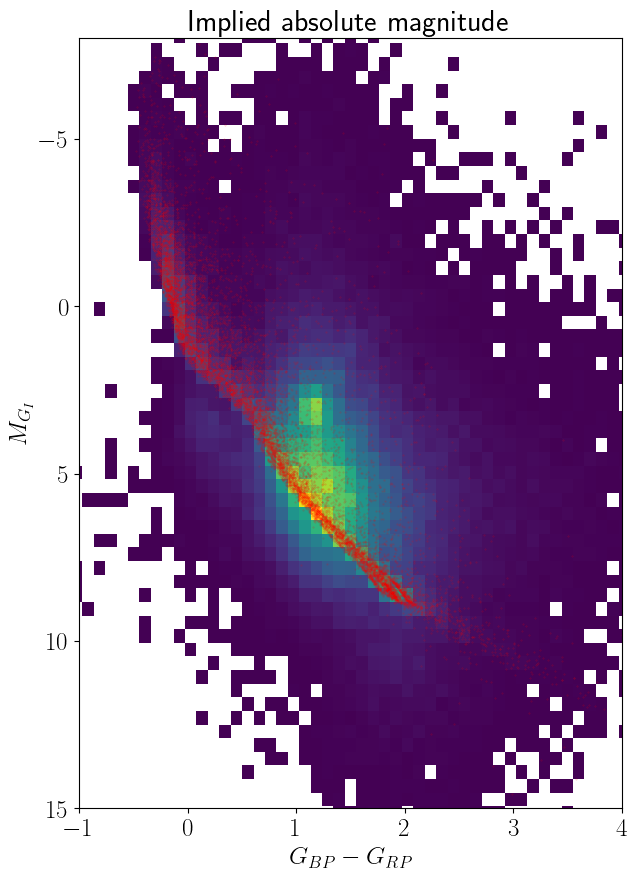

In [23]:
# plot the CMD
plt.figure(figsize=(7, 10))
plt.hist2d(data_gaia_big['bp_rp'], data_gaia_big['implied_M_g'], bins= 100, cmin= 1)
#sns.scatterplot(data=data_gaia_big, x='bp_rp', y='implied_M_g', hue='is_hvs', palette='coolwarm', s=1)
plt.scatter(data_hvs['bp_rp'], data_hvs['implied_M_g'], s=0.1, color='red', alpha=0.3)  
plt.gca().invert_yaxis()
plt.ylim(15, -8)
plt.xlim(-1, 4)
plt.xlabel('$G_{BP} - G_{RP}$')
plt.ylabel('$M_{G_I}$')
plt.title('Implied absolute magnitude')
plt.show()

## How do we classify this:

I need a method that selects stars that are in the correct position in the CMD given their implied distances, observed magntiudes and colors. I need a way to test this, which could be using speedystar.

### Fit a polynomial to the main sequence and provide a specific width

The problem here is how can we decide on the specific population to use, we could base it up on the 3 star formation burst that took place in the galactic center. Then use isochrones for populations of those ages and metalicities, and a width given by the average error propagation from the implied distance to the implied absolute magnitude.

For this we first need to implement error propagation from the implied distance to the implied absolute magntiude, which will depend entirely on the proper motion uncertainties. This could be easy using the uncertainties package

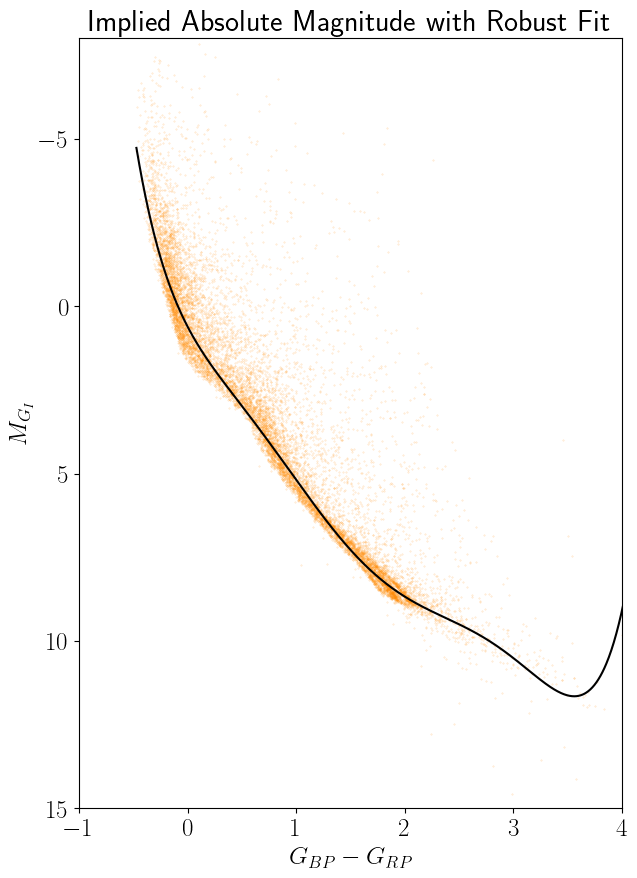

In [82]:


# Custom loss function: log(1 + abs(data - model) / (2 * sigma))
def custom_loss(coeffs, x, y, sigma=1.0):
    model = np.polyval(coeffs, x)
    residuals = y - model
    loss = np.log(1 + np.abs(residuals) / (2 * sigma))
    return np.sum(loss)

# Fit polynomial using scipy.optimize
def robust_polyfit(x, y, degree, sigma=1.0):
    # Initial guess for polynomial coefficients (from np.polyfit)
    initial_guess = np.polyfit(x, y, degree)
    
    # Minimize the custom loss function
    result = minimize(custom_loss, initial_guess, args=(x, y, sigma))
    
    return result.x  # Return optimized polynomial coefficients

# Iterate over the dataset, fitting the polynomial and removing outliers
data_hvs = data_gaia_big.loc[data_gaia_big['is_hvs'] == 1]
for i in range(10):
    # Fit a robust polynomial to the data
    polynomial_hvs_cmd = robust_polyfit(data_hvs['bp_rp'], data_hvs['implied_M_g'], degree=6, sigma=0.5)
    
    # Compute the residuals
    residuals = data_hvs['implied_M_g'] - np.polyval(polynomial_hvs_cmd, data_hvs['bp_rp'])
    
    # Remove outliers based on residual threshold
    data_hvs = data_hvs.loc[np.abs(residuals) < 0.5]

# Plot the result
data_hvs = data_gaia_big.loc[data_gaia_big['is_hvs'] == 1]
plt.figure(figsize=(7, 10))
plt.scatter(data_hvs['bp_rp'], data_hvs['implied_M_g'], s=0.1, color='darkorange', alpha=0.3)
x = np.linspace(data_hvs['bp_rp'].min(), data_hvs['bp_rp'].max(), 1000)
plt.plot(x, np.polyval(polynomial_hvs_cmd, x), color='black', label='Robust Polynomial Fit')
plt.gca().invert_yaxis()
plt.ylim(15, -8)
plt.xlim(-1, 4)
plt.xlabel('$G_{BP} - G_{RP}$')
plt.ylabel('$M_{G_I}$')
plt.title('Implied Absolute Magnitude with Robust Fit')
plt.show()


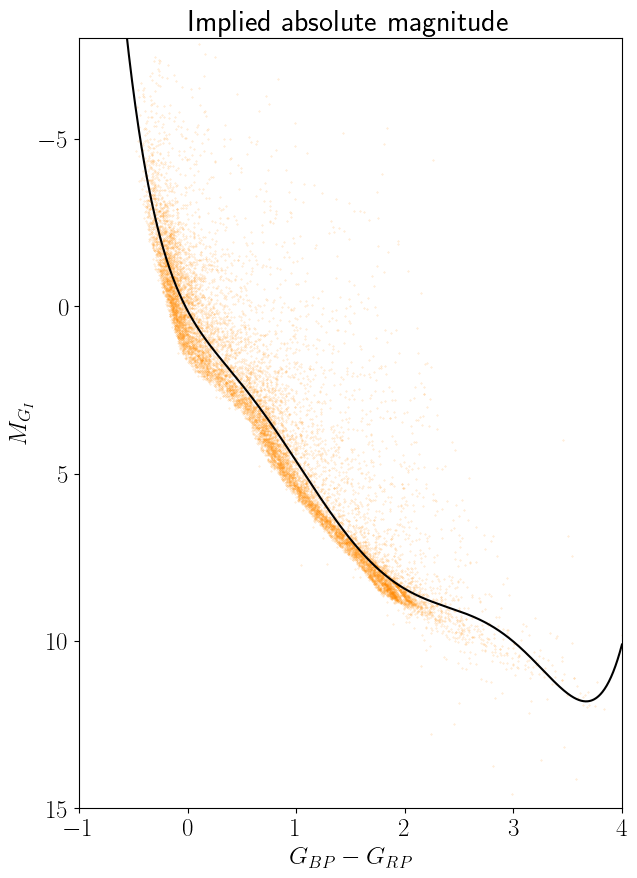

In [80]:
data_hvs = data_gaia_big.loc[data_gaia_big['is_hvs'] == 1]

# iteratively fit a polynomial and remove outliers 100 times
for i in range(1000):
    # select the sequence of HVS in the CMD and fit a polynomial
    polynomial_hvs_cmd = np.polyfit(data_hvs['bp_rp'], data_hvs['implied_M_g'], 6, )
    # compute the residuals
    residuals = data_hvs['implied_M_g'] - np.polyval(polynomial_hvs_cmd, data_hvs['bp_rp'])
    # remove the outliers
    data_hvs = data_hvs.loc[np.abs(residuals) < 0.5]
    

# plot the CMD
data_hvs = data_gaia_big.loc[data_gaia_big['is_hvs'] == 1]
plt.figure(figsize=(7, 10))
#plt.hist2d(data_gaia_big['bp_rp'], data_gaia_big['implied_M_g'], bins= 100, cmin= 1)
#sns.scatterplot(data=data_gaia_big, x='bp_rp', y='implied_M_g', hue='is_hvs', palette='coolwarm', s=1)
plt.scatter(data_hvs['bp_rp'], data_hvs['implied_M_g'], s=0.1, color='darkorange', alpha=0.3)  
plt.plot(x, np.polyval(polynomial_hvs_cmd, x), color='black', label='Polynomial fit')
plt.gca().invert_yaxis()
plt.ylim(15, -8)
plt.xlim(-1, 4)
plt.xlabel('$G_{BP} - G_{RP}$')
plt.ylabel('$M_{G_I}$')
plt.title('Implied absolute magnitude')
plt.show()

## Using an isochrone

### Machine Learning Classification

Using a catalog composed of random Gaia stars and Speedystar simulated HVS we will construct a CMD using implied distances and aparent magnitudes and colors corrected from SFD extinction

In [67]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import precision_score, recall_score



### Construct normalized training sets

In [70]:
# Step 0: Create a random subset of the data
data_subset = data_gaia_big.sample(frac=0.9, random_state=42)

# Step 1: Prepare the data
X = data_subset[['bp_rp', 'implied_M_g']]
y = data_subset['is_hvs']

# Step 2: Split into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardizing the features (important for SVM and can benefit other classifiers)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


### Stochastic Gradient Descent

In [26]:
from sklearn.linear_model import SGDClassifier
svm_classifier = SGDClassifier(loss='hinge')  # hinge loss gives SVM
svm_classifier.fit(X_train_scaled, y_train)
svm_predictions = svm_classifier.predict(X_test_scaled)

# Calculating precision and recall
svm_precision = precision_score(y_test, svm_predictions)
svm_recall = recall_score(y_test, svm_predictions)
print(f"SGD, Precision: {svm_precision}, Recall: {svm_recall}")

SGD, Precision: 0.0, Recall: 0.0


### SVM linear

In [28]:
# test with a linear kernel
svm_classifier = SVC(kernel='linear', max_iter=100)
svm_classifier.fit(X_train_scaled, y_train)
svm_predictions = svm_classifier.predict(X_test_scaled)

# Calculating precision and recall
svm_precision = precision_score(y_test, svm_predictions)
svm_recall = recall_score(y_test, svm_predictions)

print(f"SVM Kernel: {'linear'}, Precision: {svm_precision}, Recall: {svm_recall}")

SVM Kernel: linear, Precision: 0.15883262114737703, Recall: 1.0


/Users/mncavieres/opt/anaconda3/envs/speedytest2/lib/python3.12/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


In [58]:
# Step 3: Create and train the SVM model
# SVM kernels to evaluate
kernels = ['rbf', 'sigmoid', 'poly', 'linear']

# Loop through each kernel type, train, and evaluate the SVM
for kernel in kernels:
    svm_classifier = SVC(kernel=kernel)
    svm_classifier.fit(X_train_scaled, y_train)
    svm_predictions = svm_classifier.predict(X_test_scaled)
    
    # Calculating precision and recall
    svm_precision = precision_score(y_test, svm_predictions)
    svm_recall = recall_score(y_test, svm_predictions)
    
    print(f"SVM Kernel: {kernel}, Precision: {svm_precision}, Recall: {svm_recall}")

SVM Kernel: rbf, Precision: 0.9127134724857685, Recall: 0.4063644043931287
SVM Kernel: sigmoid, Precision: 0.12145636464702612, Recall: 0.12306392565474514
SVM Kernel: poly, Precision: 0.9432624113475178, Recall: 0.2996339059419882
SVM Kernel: linear, Precision: 0.0, Recall: 0.0


/Users/mncavieres/opt/anaconda3/envs/speedytest2/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Since the poly seems to be the best, I will save it to a file

In [31]:
svm_classifier = SVC(kernel='poly')
svm_classifier.fit(X_train_scaled, y_train)
svm_predictions = svm_classifier.predict(X_test_scaled)

# Calculating precision and recall
svm_precision = precision_score(y_test, svm_predictions)
svm_recall = recall_score(y_test, svm_predictions)

print(f"SVM Kernel: poly, Precision: {svm_precision}, Recall: {svm_recall}")

SVM Kernel: poly, Precision: 0.9358108108108109, Recall: 0.31711505437893533


In [30]:
import joblib 
# Save the model
joblib.dump(svm_classifier, 'svm_classifier_best.pkl')

['svm_classifier_best.pkl']

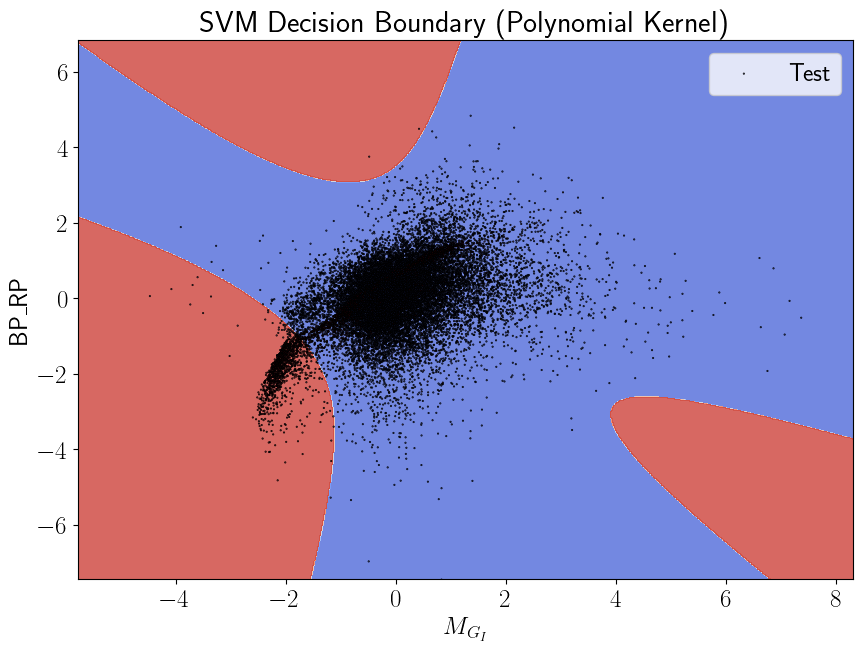

In [47]:
# plot
h = .02
x_min, x_max = X_train_scaled[:, 0].min() - 1, X_train_scaled[:, 0].max() + 1
y_min, y_max = X_train_scaled[:, 1].min() - 1, X_train_scaled[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# Step 6: Predict the classifier output for each point in the mesh
Z = svm_classifier.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)



In [ ]:
# Step 7: Plot the decision boundaries and data points
plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.coolwarm)
#plt.scatter(X_train_scaled[:, 0], X_train_scaled[:, 1], c=y_train, edgecolors='k', marker='o', cmap=plt.cm.coolwarm, label='Train')
plt.scatter(X_test_scaled[:, 0], X_test_scaled[:, 1], c=y_test, edgecolors='k', marker='.',s = 1, cmap=plt.cm.coolwarm, label='Test')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("SVM Decision Boundary (Polynomial Kernel)")
plt.xlabel('$M_{G_I}$')
plt.ylabel('BP_RP')
plt.legend()
plt.show()

/Users/mncavieres/opt/anaconda3/envs/speedytest2/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/__/n140hqf972zfmtt1hs5ldglw0000gn/T/ipykernel_46511/2827619910.py:27: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


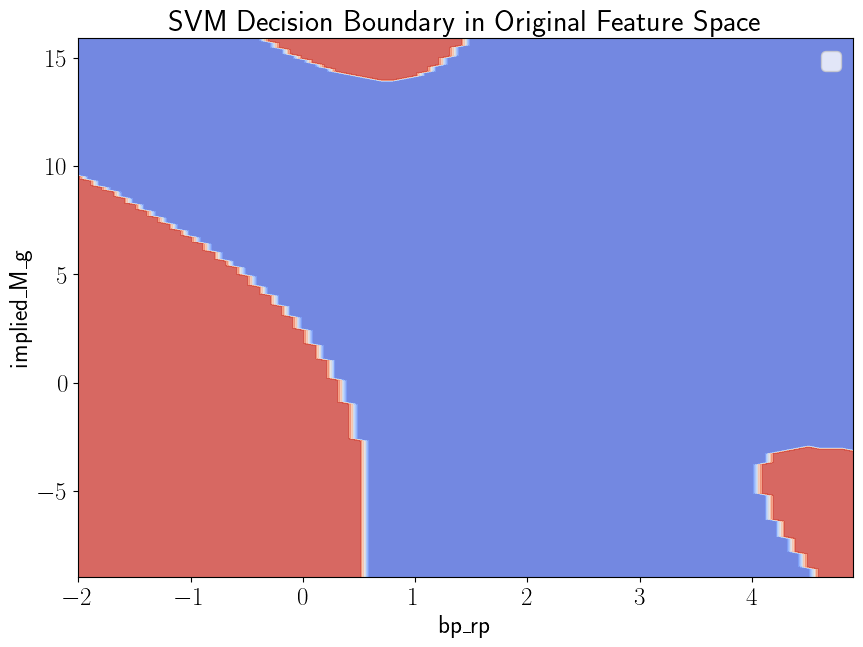

In [45]:
# Step 4: Create a mesh grid in the original data space (before scaling)
plt.ylim(15, -8)
plt.xlim(-1, 4)
h = .1  # step size in the mesh
x_min, x_max = -2,5 
y_min, y_max = -9 , 16
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))


# Step 5: Rescale the mesh grid using the same scaler as the training data
mesh_grid = np.c_[xx.ravel(), yy.ravel()]
mesh_grid_scaled = scaler.transform(mesh_grid)

# Step 6: Predict the classifier output for each point in the rescaled mesh
Z = svm_classifier.predict(mesh_grid_scaled)
Z = Z.reshape(xx.shape)

# Step 7: Plot the decision boundaries and data points in the original space
plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.coolwarm)
#plt.scatter(X['bp_rp'], X['implied_M_g'], c=y, edgecolors='k', marker='o', cmap=plt.cm.coolwarm, label='Data')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("SVM Decision Boundary in Original Feature Space")
plt.xlabel('bp_rp')
plt.ylabel('implied_M_g')
plt.legend()
plt.show()

### Random Forest Classifier

In [73]:
# Creating classifier instance
rf_classifier = RandomForestClassifier(n_estimators=5000, n_jobs= -1)

# Training classifer
rf_classifier.fit(X_train, y_train)

# Predicting the test set results
rf_predictions = rf_classifier.predict(X_test)

# Calculating precision and recall
rf_precision = precision_score(y_test, rf_predictions)
rf_recall = recall_score(y_test, rf_predictions)


print("Random Forest Precision:", rf_precision, "Random Forest Recall:", rf_recall)

Random Forest Precision: 0.7456016889514426 Random Forest Recall: 0.6064682312535775


/Users/mncavieres/opt/anaconda3/envs/speedytest2/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


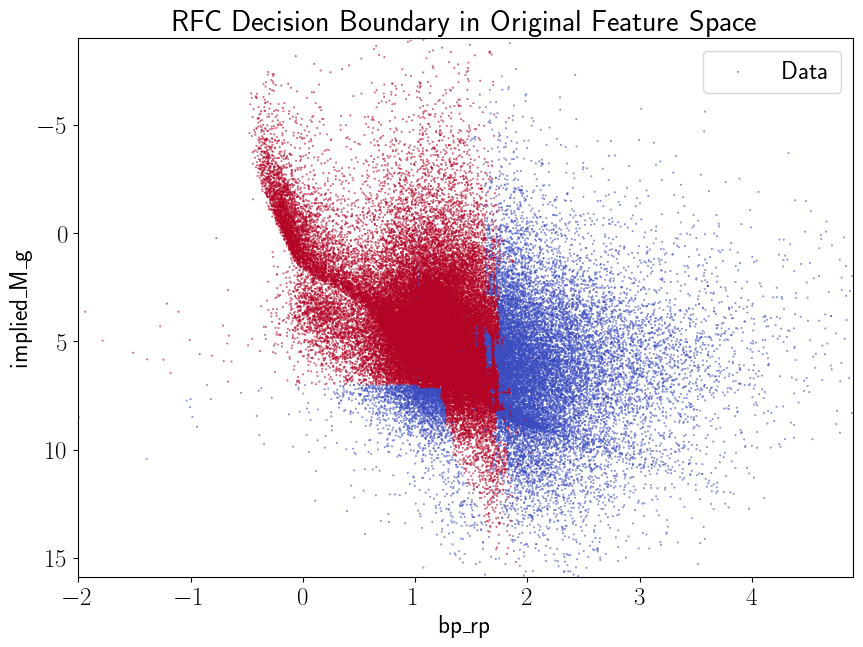

In [75]:
# Step 7: Plot the decision boundaries and data points in the original space
#plt.scatter(xx, yy, c = Z, alpha=0.8, cmap=plt.cm.coolwarm)

# Step 1: Prepare the data
X = data_subset[['bp_rp', 'implied_M_g']]
y = data_subset['is_hvs']

# Standardizing the features (important for SVM and can benefit other classifiers)
X_scaled = scaler.transform(X)
#X_scaled = scaler.transform(X)

# Predicting the test set results
rf_predictions = rf_classifier.predict(X_scaled)


plt.scatter(X['bp_rp'], X['implied_M_g'], c=rf_predictions, s = 0.1, cmap=plt.cm.coolwarm, label='Data')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("RFC Decision Boundary in Original Feature Space")
plt.xlabel('bp_rp')
plt.ylabel('implied_M_g')
plt.gca().invert_yaxis()
plt.legend()
plt.show()